<a href="https://colab.research.google.com/github/samirangode/EqWATER/blob/master/Improved_Leak_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing drive to access data
from google.colab import drive

In [ ]:
#Providing access
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#!pip install ruptures
import pandas as pd
import numpy as np
from plotnine import *
from pandas import *
import matplotlib.pyplot as plt
#import ruptures as rpt

In [ ]:
# read and store only the data required
def read_data(data_location):
  E = pd.read_csv(data_location)
  E = E[['F2','F5','F6']]
  E = abs(E)
  return E

In [ ]:
# The same as above with pressure
def read_data_with_pressure(data_location):
  E = pd.read_csv(data_location)
  E = E[['F2','F5','F6','P3']]
  E = abs(E)
  return E

In [ ]:
# visualise in the required format 
def plot(E, condition):
  ax = E[['F2','F5','F6']].plot(figsize=(25,15), grid=True)
  ax.set_xlabel("time(s)", fontsize=20)
  ax.set_ylabel("Flow(l/s)", fontsize=20)
  ax.set_title("automated intermittent supply" + condition, fontsize=20)

In [ ]:
# variation for pressure data
def plot_pressure(E, condition):
  ax = E[['P3']].plot(figsize=(25,15), grid=True)
  ax.set_xlabel("time(s)", fontsize=20)
  ax.set_ylabel("Pressure(cm)", fontsize=20)
  ax.set_title("automated intermittent supply" + condition, fontsize=20)

In [ ]:
#Find the indices of flows that have flow greater than 3 in F6 and store in a list or an array
#Using these indices take 900 time series points from each of these indices. For each sensor value.
#You will have 3*900 dataframes. Make theses numpy arrays and combine to form a 3D 3*900*n matrix where n is the number of cycles.
def findPeaks(E,noOfPeaks):
  peaks = np.zeros((3,noOfPeaks))
  from scipy.signal import find_peaks
  peaks[0], properties0 = find_peaks(np.array(E['F2']), height=0.6,distance=500)
  peaks[1], properties1 = find_peaks(np.array(E['F5']), height=2,distance=500)
  peaks[2], properties2 = find_peaks(np.array(E['F6']), height=5,distance=500)
  return peaks

In [ ]:
#Same as flow but for pressure data
def findPeaks_with_Pressure(E,noOfPeaks):
  peaks = np.zeros((4,noOfPeaks))
  from scipy.signal import find_peaks
  peaks[0], properties0 = find_peaks(np.array(E['F2']), height=0.6,distance=500)
  peaks[1], properties1 = find_peaks(np.array(E['F5']), height=2,distance=500)
  peaks[2], properties2 = find_peaks(np.array(E['F6']), height=5,distance=500)
  #temporary fix
  E_P = E[['P3']].copy()
  E_P[E_P>400] = 800
  E_P[E_P<200] = 0
  E_P = E_P.to_numpy()
  j=0
  for i in range(E_P.size):
    if(i==0):
      continue
    if((E_P[i]==800) and (E_P[i-1]<800)):
      peaks[3][j] = i
      j+=1
  return peaks

In [ ]:
##Separating no_leak, test and leak.
def selectState(E,start,end):
  start = start - 1
  end = end + 1
  E_new = E.copy()
  for col in E_new.columns:
    E_new[col].values[:start] = 0
    E_new[col].values[end:] = 0
  return E_new

In [ ]:
##Converting to numpy array because it was done in the other file
##Consider converting to numpy array in final program to remove NaN, no index errors
def convertToNumpy(E):
  return E.to_numpy()

In [ ]:
#Creating a numpy array to store the flow values for 800 instances from each peak
#3D array which will store the values for each of the sensors for all the cycles
def flowMatrix(E, peaks):
  exp = np.zeros((15*60, 3, np.size(peaks[0])))
  ########### populating exp with the flow of the different(no_leak_arr, leak,test etc.) numpy array
  for j in range(np.size(peaks[0])):
    for i in range(900):
      exp[i][0][j] = E[int(peaks[0][j]+i)][0]
  for j in range(np.size(peaks[1])):
    for i in range(900):
      exp[i][1][j] = E[int(peaks[1][j]+i)][1]
  for j in range(np.size(peaks[2])):
    for i in range(900):
      exp[i][2][j] = E[int(peaks[2][j]+i)][2]
  return exp

In [ ]:
#Same as above for pressure
def flowPressureMatrix(E, peaks, t):
  exp = np.zeros((t, 4, np.size(peaks[0])))
  ########### populating exp with the flow of the different(no_leak_arr, leak,test etc.) numpy array
  for j in range(np.size(peaks[0])):
    for i in range(t):
      exp[i][0][j] = E[int(peaks[0][j]+i)][0]
  for j in range(np.size(peaks[1])):
    for i in range(t):
      exp[i][1][j] = E[int(peaks[1][j]+i)][1]
  for j in range(np.size(peaks[2])):
    for i in range(t):
      exp[i][2][j] = E[int(peaks[2][j]+i)][2]
  for j in range(np.size(peaks[3])):
    for i in range(t):
      exp[i][3][j] = E[int(peaks[3][j]+i)][3]    
  return exp

In [ ]:
# calculating mean
def calcMean(exp):
  mean_arr = np.mean(exp, axis = 2)
  return mean_arr

In [ ]:
# calculating covariance
def calcCovwithNumpy(exp):
  covarianceMatrix = np.zeros((900,3,3))
  for i in range(exp.shape[0]):
    covarianceMatrix[i] = np.cov(exp[i])
  return covarianceMatrix + 0.000000000001

In [ ]:
#For pressure
def calcCovwithNumpyPressure(exp,t):
  covarianceMatrix = np.zeros((t,4,4))
  for i in range(exp.shape[0]):
    covarianceMatrix[i] = np.cov(exp[i])
  return covarianceMatrix

In [ ]:
# calculating covariance with self defined function
def calcCovSelf(exp,mean_arr):
  check = np.zeros((exp[:,0,0].size,3,3))
  for w in range(exp[:,0,0].size):
    for i in range(3):
      for j in range(3):
        for k in range(exp[0,0,:].size):
          check[w][i][j] += (exp[i][0][k]-mean_arr[i][0])*(exp[j][0][k]-mean_arr[j][0])

  return check/exp[0,0,:].size + np.nextafter(0, 1)


In [ ]:
## calculating the global likelihood
def calcLikelihood(mean_arrl, mean_arr, covariance_matrix_leak, covariance_matrix, expt):
  global_likelihood = np.zeros((900*expt.shape[2]))
  likelihood = np.zeros((expt.shape[2],900))
  local_likelihood = np.zeros((expt.shape[2],900))
  j=0
  for i in range(expt.shape[2]):
    for t in range(900):
      leak = (1/((2*np.math.pi)**1.5))*(1/np.linalg.det(covariance_matrix_leak[t]))*np.exp(-0.5*np.transpose(expt[t,:,i].reshape((3,1))-mean_arrl[t].reshape((3,1)))@np.linalg.inv(covariance_matrix_leak[t])@(expt[t,:,i].reshape((3,1))-mean_arrl[t].reshape((3,1))))
      no_leak = (1/((2*np.math.pi)**1.5))*(1/np.linalg.det(covariance_matrix[t]))*np.exp(-0.5*np.transpose(expt[t,:,i].reshape((3,1))-mean_arr[t].reshape((3,1)))@np.linalg.inv(covariance_matrix[t])@(expt[t,:,i].reshape((3,1))-mean_arr[t].reshape((3,1))))
      #print(t)
      if(i==0 & t==0):
        if(no_leak == 0):
          no_leak = np.nextafter(0, 1)
        likelihood[i][t] = np.log(0.000000000001 + float(leak)/float(no_leak))
        local_likelihood[i][t] = likelihood[i][t]
        global_likelihood[j] = likelihood[i][t]
        if(global_likelihood[j]<0):
          global_likelihood[j]=0
      elif(t==0):
        if(no_leak == 0):
          no_leak = np.nextafter(0, 1)
        likelihood[i][t] = np.log(0.000000000001 + float(float(leak)/float(no_leak)))
        local_likelihood[i][t] = likelihood[i][t]
        global_likelihood[j] = likelihood[i][t] + global_likelihood[j-1]
        if(global_likelihood[j]<0):
          global_likelihood[j]=0 
      else:
        if(no_leak==0):
          no_leak = np.nextafter(0,1)
        likelihood[i][t] = np.log(0.000000000001+(float(leak)/float(no_leak)))
        likelihood[i][t][np.isinf(likelihood[i][t])] = 20000
        likelihood[i][t][np.isneginf(likelihood[i][t])] = -1000
        #if(likelihood[i][t]<-20000):
        #  likelihood[i][t]=-1000
        local_likelihood[i][t] = likelihood[i][t]+ local_likelihood[i][t-1]
        global_likelihood[j] = likelihood[i][t] + global_likelihood[j-1]
        if(global_likelihood[j]>20000 or np.isinf(global_likelihood[j])):
          global_likelihood[j] = 20000
    #      if(global_likelihood[j]<-20000):
        if(global_likelihood[j]<0):
          global_likelihood[j]=0
    #        global_likelihood[j]=-20000        
      j+=1
  global_likelihood[np.isinf(global_likelihood)]=20000
  likelihood[np.isinf(likelihood)] = 20000
  return global_likelihood, likelihood

In [ ]:
## calculating global likelihood with Pressure
def calcLikelihoodPressure(mean_arrl, mean_arr, covariance_matrix_leak, covariance_matrix, expt, time):
  global_likelihood = np.zeros((time*expt.shape[2]))
  likelihood = np.zeros((expt.shape[2],time))
  local_likelihood = np.zeros((expt.shape[2],time))
  j=0
  for i in range(expt.shape[2]):
    for t in range(time):
      leak = (1/((2*np.math.pi)**1.5))*(1/np.linalg.det(covariance_matrix_leak[t]))*np.exp(-0.5*np.transpose(expt[t,:,i].reshape((4,1))-mean_arrl[t].reshape((4,1)))@np.linalg.inv(covariance_matrix_leak[t])@(expt[t,:,i].reshape((4,1))-mean_arrl[t].reshape((4,1))))
      no_leak = (1/((2*np.math.pi)**1.5))*(1/np.linalg.det(covariance_matrix[t]))*np.exp(-0.5*np.transpose(expt[t,:,i].reshape((4,1))-mean_arr[t].reshape((4,1)))@np.linalg.inv(covariance_matrix[t])@(expt[t,:,i].reshape((4,1))-mean_arr[t].reshape((4,1))))
      if(no_leak == 0):
          no_leak = np.nextafter(0, 1)
      if(i==0 & t==0):
        likelihood[i][t] = np.log(0.000000000001 + float(leak)/float(no_leak))
        local_likelihood[i][t] = likelihood[i][t]
        global_likelihood[j] = likelihood[i][t]
      elif(t==0):
        likelihood[i][t] = np.log(0.000000000001 + float(float(leak)/float(no_leak)))
        local_likelihood[i][t] = likelihood[i][t]
        global_likelihood[j] = likelihood[i][t] + global_likelihood[j-1]
        if(global_likelihood[j]<0):
          global_likelihood[j]=0
      else:
        if(no_leak==0):
          no_leak = np.nextafter(0,1)
        likelihood[i][t] = np.log(0.000000000001+(float(leak)/float(no_leak)))
        likelihood[i][t][np.isinf(likelihood[i][t])] = 20000
        likelihood[i][t][np.isneginf(likelihood[i][t])] = -1000
        local_likelihood[i][t] = likelihood[i][t]+ local_likelihood[i][t-1]
        global_likelihood[j] = likelihood[i][t] + global_likelihood[j-1]
        if(global_likelihood[j]>20000 or np.isinf(global_likelihood[j])):
          global_likelihood[j] = 20000
        if(global_likelihood[j]<0):
          global_likelihood[j]=0        
      j+=1
  global_likelihood[np.isinf(global_likelihood)]=20000
  likelihood[np.isinf(likelihood)] = 20000
  return global_likelihood, likelihood


In [ ]:
def changePoints(global_likelihood, cap):
  points = []
  for j in range(global_likelihood.size):
    if((global_likelihood[j]==cap) and (global_likelihood[j-1]<cap)):
      points.append(j)
  return points

In [ ]:
####### 11.06.20 data C3(101) and C7(100)
####Calculating
#E = read_data('/content/drive/My Drive/RA_IISc/Leak_Detection/Intermittent-Experiment/8-case-leak-detection/101/E(11.06.20_11.32_c3(101)_c7(100)).csv')

In [ ]:
####### 20.06.20 C6(010)
#E = read_data('/content/drive/My Drive/RA_IISc/Leak_Detection/Intermittent-Experiment/8-case-leak-detection/010/E(20.06.20_10.45_c6(010).csv')

In [ ]:
####### 09.06.20 C6(011)
#E = read_data('/content/drive/My Drive/RA_IISc/Leak_Detection/Intermittent-Experiment/8-case-leak-detection/011/E(09.06.20_12.22_c2(011).csv')

In [ ]:
####### 12.06.20 C4(110)
#E = read_data('/content/drive/My Drive/RA_IISc/Leak_Detection/Intermittent-Experiment/8-case-leak-detection/110/E(12.06.20_11.19_c4(110).csv')

In [ ]:
####### 22.06.20 C8(111)
#E =read_data('/content/drive/My Drive/RA_IISc/Leak_Detection/Intermittent-Experiment/8-case-leak-detection/111/E(22.06.20_10.40_c8(111).csv')

In [ ]:
####### 1.07.20 with noise
#E = read_data('/content/drive/My Drive/RA_IISc/Leak_Detection/Intermittent-Experiment/8-case-leak-detection/test/E(01.07.20_11.15_noise.csv')

In [ ]:
####### 06.07.20 with Pressure
#E = read_data_with_pressure('/content/drive/My Drive/RA_IISc/Leak_Detection/Intermittent-Experiment/Pressure/E(06.07.2020_pressure800cm).csv')
E = read_data('/content/drive/My Drive/RA_IISc/Leak_Detection/Intermittent-Experiment/Pressure/E(06.07.2020_pressure800cm).csv')

In [ ]:
####### 07.07.20 with Pressure
#E2 = read_data_with_pressure('/content/drive/My Drive/RA_IISc/Leak_Detection/Intermittent-Experiment/Pressure/E(07.07.2020_pressure800cm).csv')
E2 = read_data('/content/drive/My Drive/RA_IISc/Leak_Detection/Intermittent-Experiment/Pressure/E(07.07.2020_pressure800cm).csv')

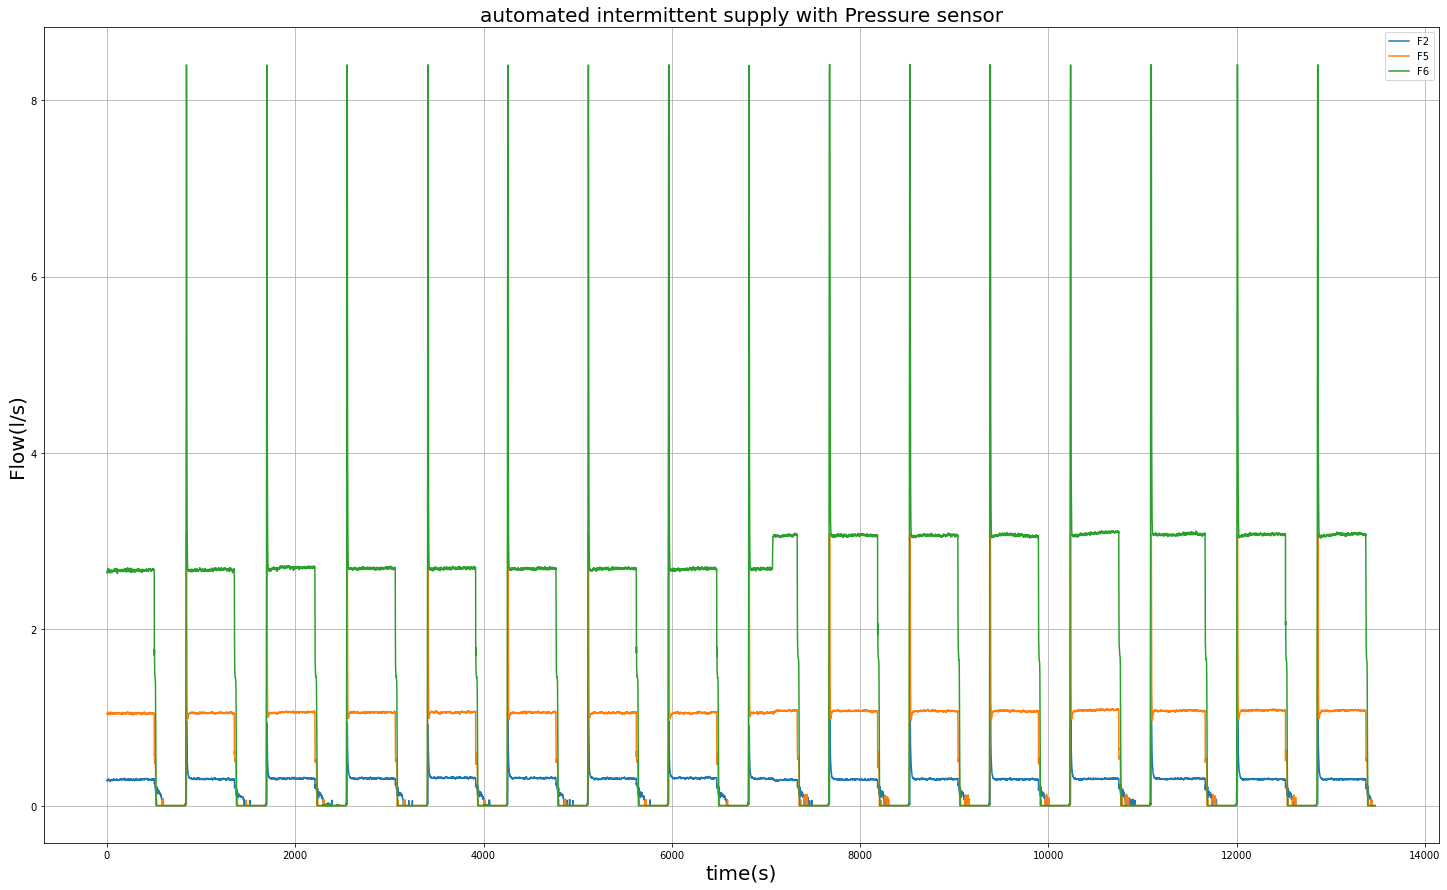

In [ ]:
plot(E," with Pressure sensor")

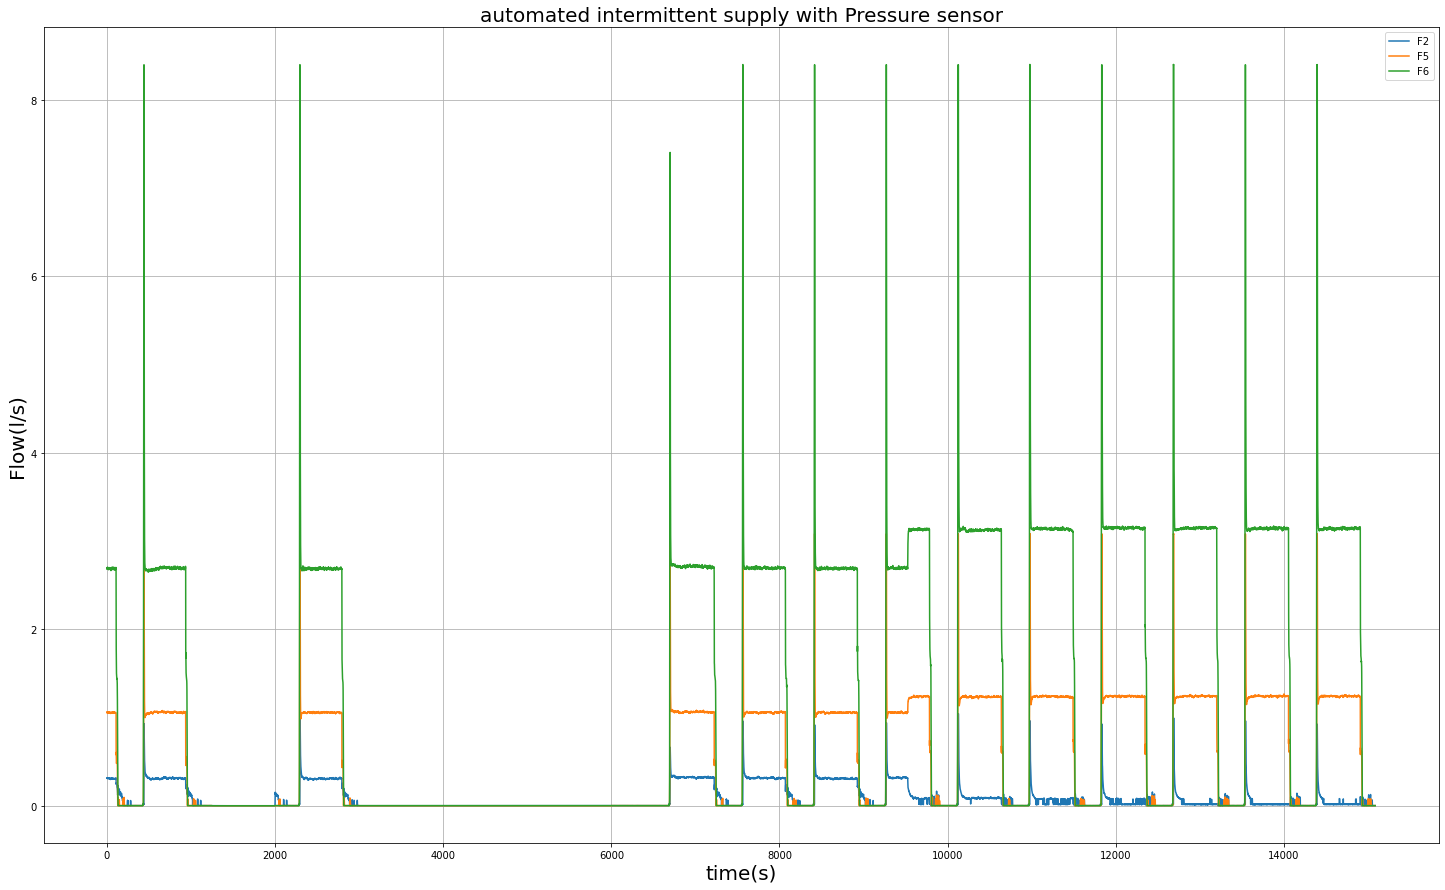

In [ ]:
plot(E2," with Pressure sensor")

In [ ]:
plot_pressure(E[150:]," P3 sensor")

In [ ]:
plot_pressure(E2," P3 sensor")

In [ ]:
#for the case E(06.07.2020)
#peaks = findPeaks_with_Pressure(E,15) 
peaks = findPeaks(E,15)                    

In [ ]:
#for the case E(07.07.2020)
peaks2 = findPeaks(E2,12)
peaks2

In [ ]:
#E_no_leak = selectState(E,100,8600) #for noise
#E_test = selectState(E,8600,10000)  #for noise
#E_leak = selectState(E,10000,19000) #for noise

In [ ]:
#E_no_leak = selectState(E,100,11500) #for C111
#E_test = selectState(E,11500,13500) #for C111
#E_leak = selectState(E,13500,24250) #for C111

In [ ]:
#E_no_leak = selectState(E,100,8600) #for C110
#E_test = selectState(E,8600,10000) #for C110
#E_leak = selectState(E,10000,21000) #for C110

In [ ]:
#E_no_leak = selectState(E,100,8600) #for C011
#E_test = selectState(E,8600, 10000) # for C011
#E_leak = selectState(E,10000, 22900) # for C011

In [ ]:
#E_no_leak = selectState(E, 100, 8600) # for C010
#E_test = selectState(E,8600,10000)    # for C010
#E_leak = selectState(E,10000,21400)   # for C010

In [ ]:
#E_no_leak = selectState(E, 100, 8600) # for C100
#E_test = selectState(E, 36400,38000)
#E_test = selectState(E, 23500, 25000) for C100
#E_test = selectState(E, 8600,10400) #for C101
#E_leak = selectState(E, 10400, 23500)# for C101
#E_leak = selectState(E, 25000, 36400)# for C100

In [ ]:
E_test3 = selectState(E,11950,12700)

In [ ]:
E_no_leak = selectState(E,800,5100) #for Pressure 06.07 (taking only 5 to keep it similar to E2)
E_test = selectState(E,6800,7600)   #for Pressure 06.07
E_leak = selectState(E,7600,12000)  #for Pressure 06.07 (taking only 5 to keep it similar to E2)

In [ ]:
E_no_leak2 = selectState(E2,150,9100) #for Pressure 07.07
E_test2 = selectState(E2,9100,10000)   #for Pressure 07.07
E_leak2 = selectState(E2,10000,14300)  #for Pressure 07.07 (taking only 5(14300) to make it equal in leak and no leak)

In [ ]:
# peaks_no_leak = findPeaks_with_Pressure(E_no_leak,5 )
# peaks_test = findPeaks_with_Pressure(E_test, 1)
# peaks_leak = findPeaks_with_Pressure(E_leak, 5)
peaks_no_leak = findPeaks(E_no_leak,5)
peaks_test = findPeaks(E,1)
peaks_leak = findPeaks(E_leak, 5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if __name__ == '__main__':


ValueError: ignored

In [ ]:
#for flow
peaks_no_leak_flow = findPeaks(E_no_leak[['F2','F5','F6']],5)
peaks_test_flow = findPeaks(E_test[['F2','F5','F6']],1)
peaks_leak_flow = findPeaks(E_leak[['F2','F5','F6']],5)

In [ ]:
peaks_no_leak2 = findPeaks_with_Pressure(E_no_leak2, 5)
peaks_test2 = findPeaks_with_Pressure(E_test2, 1)
peaks_leak2 = findPeaks_with_Pressure(E_leak2, 5)

In [ ]:
plot(E[12800:],"Pressure")

In [ ]:
expt3 = flowPressureMatrix(convertToNumpy(E_test3), peaks_test, 480)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1

In [ ]:
#expnl = flowMatrix(convertToNumpy(E_no_leak),peaks_no_leak)
expnl = flowPressureMatrix(convertToNumpy(E_no_leak),peaks_no_leak, 480)
expt = flowPressureMatrix(convertToNumpy(E_test), peaks_test, 480)
expl = flowPressureMatrix(convertToNumpy(E_leak),peaks_leak, 480)

In [ ]:
expnl2 = flowPressureMatrix(convertToNumpy(E_no_leak2),peaks_no_leak2,480)
expt2 = flowPressureMatrix(convertToNumpy(E_test2), peaks_test2, 480)
expl2 = flowPressureMatrix(convertToNumpy(E_leak2),peaks_leak2, 480)

In [ ]:
mean_arr_no_leak = calcMean(expnl)
mean_arr_leak = calcMean(expl)

In [ ]:
mean_arr_no_leak2 = calcMean(expnl2)
mean_arr_leak2 = calcMean(expl2)

In [ ]:
covariance_no_leak = calcCovwithNumpyPressure(expnl,480)
covariance_leak = calcCovwithNumpyPressure(expl,480)

In [ ]:
covariance_no_leak2 = calcCovwithNumpyPressure(expnl2,480)
covariance_leak2 = calcCovwithNumpyPressure(expl2,480)

In [ ]:
#covariance_no_leak_self = calcCovSelf(expnl2,mean_arr_no_leak)
#covariance_leak_self = calcCovSelf(expl2,mean_arr_leak)

In [ ]:
global_likelihood, likelihood = calcLikelihoodPressure(mean_arr_leak, mean_arr_no_leak, covariance_leak, covariance_no_leak, expt, 480)

In [ ]:
global_likelihood2, likelihood2 = calcLikelihoodPressure(mean_arr_leak2, mean_arr_no_leak2, covariance_leak2, covariance_no_leak2, expt, 480)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  This is separate from the ipykernel package so we can avoid doing imports until


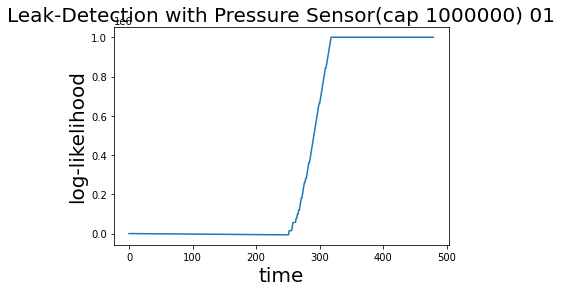

In [ ]:
#plt.plot(global_likelihood)
#plt.plot(likelihood[0][0:50])
new_gl = np.zeros(global_likelihood.shape)
new_gl[0] = global_likelihood[0]
for t in range(global_likelihood.size):
  if(t==0):
    new_gl[0] = global_likelihood[0]
  else:
    new_gl[t] = likelihood[0][t] + new_gl[t-1]
    if(new_gl[t]>1000000):
      new_gl[t]=1000000
plt.xlabel("time", fontsize=20)
plt.ylabel("log-likelihood", fontsize=20)
plt.title("Leak-Detection with Pressure Sensor(cap 1000000) 01", fontsize=20)
plt.plot(new_gl)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """Entry point for launching an IPython kernel.


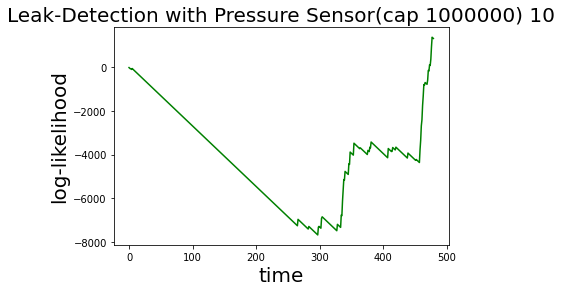

In [ ]:
new_gl2 = np.zeros(global_likelihood2.shape)
new_gl2[0] = global_likelihood2[0]
for t in range(global_likelihood2.size):
  if(t==0):
    new_gl2[0] = global_likelihood2[0]
  else:
    new_gl2[t] = likelihood2[0][t] + new_gl2[t-1]
    if(new_gl2[t]>1000000):
      new_gl2[t]=1000000
plt.xlabel("time", fontsize=20)
plt.ylabel("log-likelihood", fontsize=20)
plt.title("Leak-Detection with Pressure Sensor(cap 1000000) 10", fontsize=20)
plt.plot(new_gl2,'g')

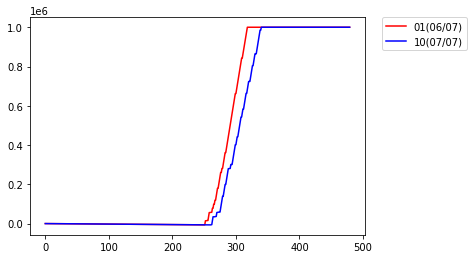

In [ ]:
#global_likelihood[600]
#likelihood[0][600]
#plt.plot(global_likelihood)
plt.plot(new_gl,'r', label = "01(06/07)")
plt.plot(new_gl2,'b', label = "10(07/07)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

In [ ]:
points = changePoints(new_gl, 1000000)
points

[318]

In [ ]:
def test(mean_arrl, mean_arr, covariance_matrix_leak, covariance_matrix, expt):
  global_likelihood = np.zeros((900*expt.shape[2]))
  likelihood = np.zeros((expt.shape[2],900))
  local_likelihood = np.zeros((expt.shape[2],900))
  j=0
  for i in range(expt.shape[2]):
    for t in range(900):
      leak = (1/((2*np.math.pi)**1.5))*(1/np.linalg.det(covariance_matrix_leak[t]))*np.exp(-0.5*np.transpose(expt[t,:,i].reshape((3,1))-mean_arrl[t].reshape((3,1)))@np.linalg.inv(covariance_matrix_leak[t])@(expt[t,:,i].reshape((3,1))-mean_arrl[t].reshape((3,1))))
      no_leak = (1/((2*np.math.pi)**1.5))*(1/np.linalg.det(covariance_matrix[t]))*np.exp(-0.5*np.transpose(expt[t,:,i].reshape((3,1))-mean_arr[t].reshape((3,1)))@np.linalg.inv(covariance_matrix[t])@(expt[t,:,i].reshape((3,1))-mean_arr[t].reshape((3,1))))
      #print(t)
      if(i==0 & t==0):
        if(no_leak == 0):
          no_leak = np.nextafter(0, 1)
        likelihood[i][t] = np.log(0.000000000001 + float(leak)/float(no_leak))
        local_likelihood[i][t] = likelihood[i][t]
        global_likelihood[j] = likelihood[i][t]
        if(global_likelihood[j]<0):
          global_likelihood[j]=0
      elif(t==0):
        if(no_leak == 0):
          no_leak = np.nextafter(0, 1)
        likelihood[i][t] = np.log(0.000000000001 + float(float(leak)/float(no_leak)))
        local_likelihood[i][t] = likelihood[i][t]
        global_likelihood[j] = likelihood[i][t] + global_likelihood[j-1]
        if(global_likelihood[j]<0):
          global_likelihood[j]=0 
      else:
        if(no_leak==0):
          no_leak = np.nextafter(0,1)
        likelihood[i][t] = np.log(0.000000000001+(float(leak)/float(no_leak)))
        #likelihood[i][t][np.isinf(likelihood[i][t])] = 20000
        #likelihood[i][t][np.isneginf(likelihood[i][t])] = -1000
        local_likelihood[i][t] = likelihood[i][t]+ local_likelihood[i][t-1]
        global_likelihood[j] = likelihood[i][t] + global_likelihood[j-1]
        #if(global_likelihood[j]>20000 or np.isinf(global_likelihood[j])):
        #  global_likelihood[j] = 20000
    #      if(global_likelihood[j]<-20000):
        #if(global_likelihood[j]<0):
        #  global_likelihood[j]=0
    #        global_likelihood[j]=-20000        
      j+=1
  #global_likelihood[np.isinf(global_likelihood)]=20000
  #likelihood[np.isinf(likelihood)] = 20000
  return global_likelihood, likelihood


In [ ]:
gl_test, likeli_test = test(mean_arr_leak,mean_arr_no_leak,covariance_leak, covariance_no_leak,ex)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: The p

In [ ]:
#new_gl_010 = new_gl
#new_gl_011 = new_gl
#new_gl_110_mil = new_gl
#new_gl_110 = new_gl
#new_gl_111_mil = new_gl
#new_gl_111 = new_gl

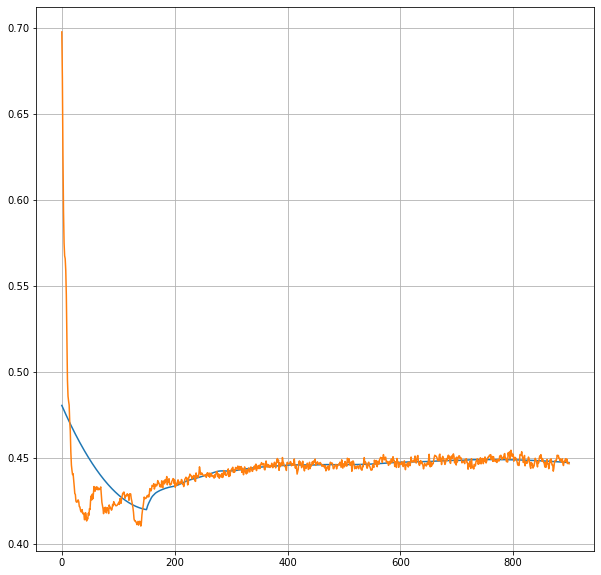

In [ ]:
import scipy
test = scipy.signal.savgol_filter(mean_arr_no_leak[:,0],301,2)
testl = scipy.signal.savgol_filter(mean_arr_leak[:,0],301,2)
plt.figure(figsize=(10,10))
plt.grid(True)
plt.plot(test)
#plt.plot(testl)
plt.plot(mean_arr_no_leak[:,0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


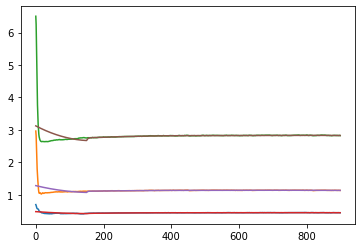

In [ ]:
test_mean_no_leak = np.zeros((900,3))
test_mean_leak = np.zeros((900,3))
for i in range(3):
  test_mean_no_leak[:,i] = scipy.signal.savgol_filter(mean_arr_no_leak[:,i],301,2)
  test_mean_leak[:,i] = scipy.signal.savgol_filter(mean_arr_leak[:,i],301,2)
plt.plot(mean_arr_no_leak)
plt.plot(test_mean_no_leak)